In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor


Importing Data


In [2]:
# converting csv file for training and testing into dataframe
df = pd.read_csv('/content/drive/MyDrive/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/test.csv')

In [4]:
df.head()

,labels,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_1190,f_1191,f_1192,f_1193,f_1194,f_1195,f_1196,f_1197,f_1198,f_1199
0,0,-2.033875,0.978446,-0.142131,-0.177117,-1.470684,1.669562,-0.196530,-0.125239,-0.452284,...,-1.111266,0.716084,0.060039,0.301279,-1.174846,-1.076498,-0.069452,-0.604012,-2.179176,0.558003
1,1,-0.348835,0.294815,-0.557577,-2.020773,-1.234715,1.633930,-1.680658,-0.358146,0.166122,...,0.735240,0.829781,1.521941,1.347946,0.754505,1.330642,-0.754453,0.582956,0.252671,1.495870
2,1,0.113248,-0.607726,-0.947791,0.830851,0.998291,0.498321,-1.493958,0.789572,-1.311018,...,0.104698,0.616189,-1.035953,2.111387,-0.984415,1.148076,-1.433554,0.243372,0.170083,1.274795
3,0,1.223321,-0.479048,-1.925789,1.680377,0.021840,-1.453307,0.605559,-0.019024,1.065448,...,0.360237,-1.957863,-0.123384,1.505329,0.660290,-1.769443,-0.547756,-0.568122,0.244645,0.982116
4,0,0.160109,0.422684,-0.308029,0.227744,0.432854,0.608348,0.193832,1.035091,-0.538868,...,0.416629,1.441766,0.212572,-0.994721,1.143999,-2.166923,-1.199248,-1.028636,0.752791,0.317169


Spliting in Training and Validation Set

In [3]:
from sklearn.model_selection import train_test_split

# Specify the features (X) and the target variable (y)
X = df.drop('labels', axis=1)  # Replace 'target_variable' with actual target column name
y = df['labels']

# Split the data into train and test sets
test_size = 0.2
random_state = 42  # Set a random seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# Create train and test dataframes
train_df = pd.concat([y_train, X_train ], axis=1)
cv_df = pd.concat([ y_test, X_test], axis=1)

Creating Custom Dataset

In [5]:
# since the image is already preprocessed first we need to quantize the channels so that we can learn the co-occurences between pixel values
# Original features are converted into input tensor(3*36*36) containing 3 channels with their co-occurence matrices

class CustomDataset(Dataset):
    def __init__(self, df, num_bins):
        self.data = df
        self.num_bins = num_bins

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data.iloc[index]

        # Convert string features to list of floats
        features = torch.tensor(sample[1:]).view(3, 20, -1)
        features = torch.tensor(features, dtype=torch.float32)

        # Compute co-occurrence matrices
        co_occurrence_matrices = compute_co_occurrence_matrices(features, self.num_bins)

        label = torch.tensor([sample[0]])
        label = label.to(torch.float32)

        train_ex = {'features': co_occurrence_matrices, 'label': label}

        return train_ex


def quantize_image(image, num_bins):
    min_val = torch.min(image)
    max_val = torch.max(image)
    quantized_image = (image - min_val) / (max_val - min_val)  # Rescale image between 0 and 1
    quantized_image *= (num_bins - 1)  # Scale to fit within the range of bins
    quantized_image = torch.round(quantized_image)  # Round to the nearest integer
    return quantized_image


def compute_co_occurrence_matrices(image, num_bins):
    quantized_image = quantize_image(image, num_bins)

    # Convert image to numpy array
    image_np = np.array(quantized_image)

    # Compute co-occurrence matrices
    co_occurrence_matrices = []
    for channel in range(3):  # Iterate over RGB channels
        channel_np = image_np[channel].astype(np.int64)  # Convert to integer type
        co_occurrence_matrix = np.zeros((num_bins, num_bins))
        for i in range(channel_np.shape[0]):
            for j in range(channel_np.shape[1]):
                co_occurrence_matrix[channel_np[i, j], channel_np[i, (j + 1) % channel_np.shape[1]]] += 1
        co_occurrence_matrices.append(co_occurrence_matrix)

    # Convert co-occurrence matrices to tensor
    co_occurrence_matrices = torch.tensor(co_occurrence_matrices, dtype=torch.float32)

    return co_occurrence_matrices

train_set=CustomDataset(train_df,36)
cv_set = CustomDataset(cv_df,36)
test_set=CustomDataset(df_test,36)

Loading Data

In [7]:
import random
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Initialize the training data loader with shuffle=True and random seed
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True, generator=torch.Generator().manual_seed(seed))
test_dataloader = DataLoader(test_set, batch_size=32, shuffle=False)
cv_dataloader = DataLoader(cv_set, batch_size=32, shuffle=False)


Model Architecture

In [11]:

import random

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

class Co_matrix(torch.nn.Module):
    def __init__(self):
        super(Co_matrix, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1, stride =1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=5, padding=2, stride =1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1, stride =1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=5, padding=2, stride =1),
            nn.MaxPool2d(kernel_size=2, stride=2)


        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 9* 9, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1),  # Modify num_classes as needed
           )

        self.sigmoid = torch.nn.Sigmoid()

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.classifier(x)
        x = self.sigmoid(x)
        return x




# Create an instance of the ConvNet
model_co_matrices = Co_matrix()
loss_fn = torch.nn.BCELoss()

Training Loop

In [12]:

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, sample in enumerate(dataloader):


        # Compute prediction error
        pred = model(sample['features'])
        loss = loss_fn(pred, sample['label'])


        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()



def calculate_error(dataloader, model, loss_fn, error_type):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    error = 0
    with torch.no_grad():
        for batch, sample in enumerate(dataloader):
            pred = model(sample['features'])
            error += loss_fn(pred, sample['label']).item()


    error /= num_batches
    return error




Tuning learning rate


Training with learning rate: 0.0005
-------------------------------
Epoch 1


<ipython-input-5-dd6e5a7dec89>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features, dtype=torch.float32)


Epoch 2
Epoch 3
Epoch 4
Epoch 5

Training with learning rate: 0.001
-------------------------------
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5

Training with learning rate: 0.005
-------------------------------
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5

Training with learning rate: 0.01
-------------------------------
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5

Training with learning rate: 0.05
-------------------------------
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5

Training with learning rate: 0.1
-------------------------------
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5


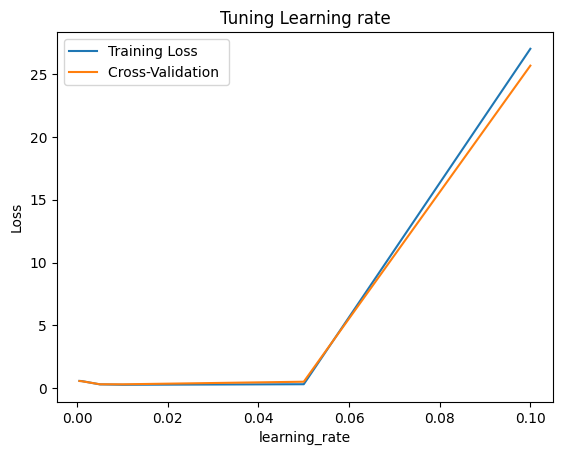

[0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
[0.5913642389756261, 0.579251617193222, 0.3152505364269018, 0.28389470290505525, 0.32772092363148025, 26.988636363636363]
[0.5830166412122322, 0.5679746504985925, 0.3252123070485664, 0.32084786666162085, 0.527396635575728, 25.64830999663382]


In [13]:
import matplotlib.pyplot as plt

learning_rates = [0.0005,0.001,0.005,0.01, 0.05,0.1] # Add the learning rates you want to tune

train_loss_history = []
cv_loss_history = []

for lr in learning_rates:
    torch.manual_seed(seed)  # Reset the random seed for each learning rate
    model_co_matrices = Co_matrix()  # Recreate the model with the same randomly initialized parameters

    optimizer = torch.optim.SGD(model_co_matrices.parameters(), lr=lr, momentum=0.9)  # Update the learning rate

    print(f"\nTraining with learning rate: {lr}\n-------------------------------")

    for epoch in range(5):
        print(f"Epoch {epoch+1}")
        train(train_dataloader, model_co_matrices, loss_fn, optimizer)
        train_loss = calculate_error(train_dataloader, model_co_matrices, loss_fn, "cv_loss")
        cv_loss = calculate_error(cv_dataloader, model_co_matrices, loss_fn, "cv_loss")



    train_loss_history.append(train_loss)
    cv_loss_history.append(cv_loss)

    # Save the model
    torch.save(model_co_matrices, f"model_lr_{lr}.pth")


plt.plot(learning_rates, train_loss_history, label=f"Training Loss ")
plt.plot(learning_rates, cv_loss_history, label=f"Cross-Validation ")
plt.xlabel('learning_rate')
plt.ylabel('Loss')
plt.title('Tuning Learning rate')
plt.legend()
plt.show()

print(learning_rates)
print(train_loss_history)
print(cv_loss_history)


Making Predictions with Selected model

In [14]:
print(f"selected learning rate: 0.01")
model = torch.load("model_lr_0.01.pth")


# Make predictions
pred_test = []
id_list = []
for batch, sample in enumerate(test_dataloader):
    with torch.no_grad():
        # Compute prediction
        pred = model(sample['features'])
        id = sample['label']
        predicted_labels = pred.round()
        pred_test.extend(predicted_labels.tolist())
        id_list.extend(id.tolist())

# Process the predictions and IDs as needed
pred_test = [tensor[0] for tensor in pred_test]
id_list = [tensor[0] for tensor in id_list]

# Create a DataFrame with the predictions
import pandas as pd
data = {'id': id_list, 'label': pred_test}
df = pd.DataFrame(data)
df['id'] = df['id'].astype(int)
df['label'] = df['label'].astype(int)
df.head()





selected learning rate: 0.01


<ipython-input-5-dd6e5a7dec89>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features, dtype=torch.float32)


,id,label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [ ]:
print("Obtained F1 score on test set : 0.76221498" )

In [15]:
from google.colab import  drive
drive.mount('/drive')
df.to_csv('/drive/My Drive/Gen_AI_model_co_occ_matrix_2_csv_file.csv')

Mounted at /drive
